In [1]:
import sys
import math

from PIL import Image

import numpy as np
from bisect import bisect_left

from pyvox.models import Vox
from pyvox.writer import VoxWriter
from pyvox.parser import VoxParser

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

from pprint import pprint

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bezier_gradient(ref_colors, output_num=100):
    n_ref = len(ref_colors) - 1

    fact_cache = {}
    def fact(n):
        ''' Memorized factorial function '''
        try:
            return fact_cache[n]
        except(KeyError):
            if n == 1 or n == 0:
                result = 1
            else:
                result = n*fact(n-1)
            fact_cache[n] = result
            return result

    def bernstein(t, n, i):
        ''' Bernstein coefficient '''
        binom = fact(n)/float(fact(i)*fact(n - i))
        return binom*((1-t)**(n-i))*(t**i)

    def bezier_interp(t):
            ''' Define an interpolation function
                for this specific curve'''
            # List of all summands
            summands = [
                list(map(lambda x: int(bernstein(t, n_ref, i)*x), c)) for i, c in enumerate(ref_colors)
            ]

            # Output color
            out = [0,0,0]
            # Add components of each summand together
            for vector in summands:
                for c in range(3):
                    out[c] += vector[c]

            return out

    gradient = [
        bezier_interp(float(t)/(output_num-1)) for t in range(output_num)
    ]
    return gradient

In [3]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]


def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
        colors in RGB and hex form for use in a graphing function
        defined later on '''
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def control_points_from_colors(gradient):
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def plot_gradient_series(color_dict, pointsize=100, control_points=None, filename=None):
        ''' Take a dictionary containing the color
            gradient in RBG and hex form and plot
            it to a 3D matplotlib device '''

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        xcol = color_dict["r"]
        ycol = color_dict["g"]
        zcol = color_dict["b"]

        # If bezier control points passed to function,
        # plot along with curve
        if control_points != None:
            xcntl = control_points["r"]
            ycntl = control_points["g"]
            zcntl = control_points["b"]
            ax.scatter( xcntl, ycntl, zcntl,
                        c=control_points["hex"],
                        s=pointsize, marker='s')

        # We can pass a vector of colors corresponding to each point
        ax.scatter(xcol, ycol, zcol, c=color_dict["hex"], s=pointsize)

        ax.set_xlabel('Red Value')
        ax.set_ylabel('Green Value')
        ax.set_zlabel('Blue Value')
        ax.set_zlim3d(0,255)
        plt.ylim(0,255)
        plt.xlim(0,255)

        if not filename is None:
            # Save two views of each plot
            ax.view_init(elev=15, azim=68)
            plt.savefig(filename + ".svg")
            ax.view_init(elev=15, azim=28)
            plt.savefig(filename + "_view_2.svg")

        # Show plot for testing
        plt.show()

[(0, 0, 255), (0, 230, 64), (255, 203, 5)]
[[0, 0, 255], [1, 28, 229], [4, 56, 205], [10, 81, 183], [18, 103, 162], [28, 124, 141], [40, 142, 121], [55, 158, 104], [72, 171, 87], [91, 183, 71], [113, 192, 58], [137, 198, 45], [163, 202, 33], [191, 205, 21], [222, 204, 12], [255, 203, 5]]


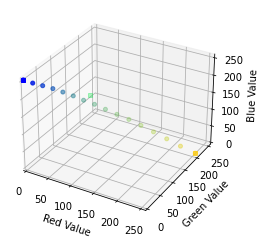

In [4]:
ref_colors = [(0,0,255), (0, 230, 64), (255, 203, 5)]

print(ref_colors)
num_colors = 256 // 16

gradient = bezier_gradient(ref_colors, num_colors)
print(gradient)

plot_gradient_series(color_dict(gradient),
                     pointsize=num_colors,
                     control_points=control_points_from_colors(ref_colors)
                    )

In [5]:
def computeACoeff(x1, x2, y1, y2, k):
    return k*(x2 - x1) - (y2 -y1)

def computeBCoeff(x1, x2, y1, y2, k):
    return -k*(x2 - x1) + (y2 -y1)

def findLowerBound(xvalues, x):
    if xvalues[-1] == x:
        return len(xvalues) - 2
    left = bisect_left(xvalues, x)
    if left >= len(xvalues):
        return len(xvalues) - 1
    if (xvalues[left]==x):
        return 0 if left == 0 else left - 1
    return left - 1

class CubicSplineStruct:
    def __init__(self):
        self.m_n = 0
        self.m_xvalues = []
        self.m_yvalues = []
        self.m_kMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_yMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_ytoKMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_kCoeffs = []
    def pushFirstEquationToKMatrix(self, x0, x1):
        self.m_kMatrix[0, 0] = 2./(x1 - x0)
        self.m_kMatrix[0, 1] = 1./(x1 - x0)
    def pushLastEquationToKMatrix(self, xnm1, xn):
        self.m_kMatrix[-1, -1] = 2./(xn - xnm1)
        self.m_kMatrix[-1, -2] = 1./(xn - xnm1)
    def pushMiddleEquationToKMatrix(self, i, xim1, xi, xip1):
        self.m_kMatrix[i, i-1] = 1./(xi - xim1)
        self.m_kMatrix[i, i] = 2./(xi - xim1) + 2./(xip1 - xi)
        self.m_kMatrix[i, i + 1] = 1./(xip1 - xi)
    def computeKMatrix(self):
        self.m_kMatrix = np.matrix(np.zeros(shape=(self.m_n, self.m_n)))
        self.pushFirstEquationToKMatrix(self.m_xvalues[0], self.m_xvalues[1])
        for i in range(1, self.m_n-1):
            self.pushMiddleEquationToKMatrix(i, self.m_xvalues[i-1], self.m_xvalues[i], self.m_xvalues[i+1])
        self.pushLastEquationToKMatrix(self.m_xvalues[-2], self.m_xvalues[-1])
    def pushFirstEquationToYMatrix(self, x0, x1):
        self.m_yMatrix[0, 0] = -3./(x1 - x0)**2
        self.m_yMatrix[0, 1] = 3./(x1 - x0)**2
    def pushLastEquationToYMatrix(self, xnm1, xn):
        self.m_yMatrix[-1, -1] = 3./(xn - xnm1)**2
        self.m_yMatrix[-1, -2] = -3./(xn - xnm1)**2

    def pushMiddleEquationToYMatrix(self, i, xim1, xi, xip1):
        self.m_yMatrix[i, i-1] = -3./(xi - xim1)**2
        self.m_yMatrix[i, i] = 3./(xi - xim1)**2 - 3./(xip1 - xi)**2
        self.m_yMatrix[i, i + 1] = 3./(xip1 - xi)**2
    def computeYMatrix(self):
        self.m_yMatrix = np.matrix(np.zeros(shape=(self.m_n, self.m_n)))
        self.pushFirstEquationToYMatrix(self.m_xvalues[0], self.m_xvalues[1])
        for i in range(1, self.m_n-1):
            self.pushMiddleEquationToYMatrix(i, self.m_xvalues[i-1], self.m_xvalues[i], self.m_xvalues[i+1])
        self.pushLastEquationToYMatrix(self.m_xvalues[-2], self.m_xvalues[-1])
    def computeYtoKMatrix(self):
        self.computeKMatrix()
        self.computeYMatrix()
        self.m_ytoKMatrix = self.m_kMatrix.I*self.m_yMatrix
    def computeKCoeffs(self):
        kCoeffs = np.array(self.m_yvalues)*self.m_ytoKMatrix.T
        self.m_kCoeffs = [kCoeffs[0, i] for i in range(self.m_n)]
    def interpolateOnInterval(self, intervalIndex, x):
        x1 = self.m_xvalues[intervalIndex]
        x2 = self.m_xvalues[intervalIndex+1]
        y1 = self.m_yvalues[intervalIndex]
        y2 = self.m_yvalues[intervalIndex+1]
        t = (x - x1)/(x2 - x1)
        a = computeACoeff(x1, x2, y1, y2, self.m_kCoeffs[intervalIndex])
        b = computeBCoeff(x1, x2, y1, y2, self.m_kCoeffs[intervalIndex+1])
        return (1-t)*y1 + t*y2 + t*(1-t)*(a*(1-t)+b*t)
    def interpolate(self, x):
        if len(self.m_xvalues) == 0:
            return 0.
        intervalLowerBound = findLowerBound(self.m_xvalues, x)
        return self.interpolateOnInterval(intervalLowerBound, x)

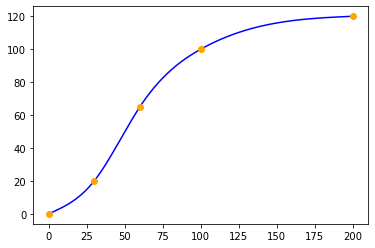

In [6]:
#hlevels_ref_x = [0, 30, 60, 100, 200]
#hlevels_ref_y = [0, 20, 70, 100, 110]

hlevels_ref_x = [0, 30, 60, 100, 200]
hlevels_ref_y = [0, 20, 65, 100, 120]

#hlevels_ref_x = [0, 10, 50, 100, 200]
#hlevels_ref_y = [0, 5, 70, 100, 110]

hlevels_spline = CubicSplineStruct()
hlevels_spline.m_n = len(hlevels_ref_x)
hlevels_spline.m_xvalues =  hlevels_ref_x
hlevels_spline.computeYtoKMatrix()
hlevels_spline.m_yvalues = hlevels_ref_y
hlevels_spline.computeKCoeffs()

x_steps = 10
hlevels_x = [x / x_steps for x in range(min(hlevels_ref_x) * x_steps, max(hlevels_ref_x) * x_steps)]
hlevels_y = [hlevels_spline.interpolate(x) for x in hlevels_x]

plt.plot(hlevels_x, hlevels_y, '-b')
plt.plot(hlevels_ref_x, hlevels_ref_y, 'o', color='orange')
plt.show()

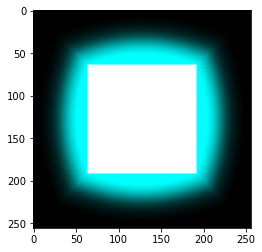

(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)

(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)

(255, 255, 255, 255)
(255, 255, 255, 255)
(255, 255, 255, 255)
(255, 255, 255, 255)

(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 238, 238, 255)


In [7]:
src_base_l = 64 * 2
src_base_w = src_base_l
src_base_h = src_base_l
border = src_base_l // 2

h0 = src_base_w / 2. + border - 0.5
v0 = src_base_h / 2. + border - 0.5

def generate_tile_data(pixels, points, hbase=0, vbase=0):
    hmap = np.zeros((src_base_w + border * 2, src_base_h + border * 2))
    for voff in range(src_base_h + 2*border):
        for hoff in range(src_base_w + 2*border):

            ur = (float(hoff) - h0) / float(src_base_w)
            vr = (float(voff) - v0) / float(src_base_h)
            
            max_hraw = 10
            hraw = 0
            hlevel = 0
            for up, vp in points:
                u = (ur - up)
                v = (vr - vp)
                d_euc = math.sqrt(u*u + v*v)
                d_max = max(abs(u), abs(v))
                d = ( d_euc + d_max ) / 2.0

                #doffset = 0.15 ; pow_k = 1.1 ; hdiv = 1.0 ; hoffset = 1.25
                #doffset = 0.130 ; pow_k = 1.1 ; hdiv = 1.0 ; hoffset = 1.17

                doffset = 0.12 ; pow_k = 1.1 ; hdiv = 1.0 ; hoffset = 1.23

                if d > doffset:
                    hlevel += min(1.0, max(0, 1.0 / math.pow(d - doffset, pow_k) / hdiv - hoffset ))
                    hraw += min(max_hraw, max(0, 1.0 / math.pow(d - doffset, pow_k) / hdiv - hoffset ))
                else:
                    hlevel += 1.0
                    hraw += max_hraw

            hmap[hoff, voff] = max(0, hraw)
            hlevel = min(1, max(0, hlevel))

            hlevel = hlevels_spline.interpolate(hlevel * 100.0) / 100.0

            if hoff >= border and hoff < src_base_w + border and \
               voff >= border and voff < src_base_h + border:
                r, g, b = hlevel * 128, hlevel * 128, hlevel * 128
            else:
                r, g, b = hlevel * 0, hlevel * 128, hlevel * 128

            f = 2
            pixels[hbase + hoff, vbase + voff] = ( int(r * f), int(g * f), int(b * f), int(255) )

    return hmap
            
points = [ (0, 0) ]
vbase = 0
hbase = 0

img = Image.new('RGBA', (src_base_w + border * 2, src_base_h + border * 2), (0, 0, 0, 0))
pixels = img.load()
hmap = generate_tile_data(pixels, points, hbase, vbase)
plt.imshow(img)
plt.show()

print(img.getpixel((0, 0)))
print(img.getpixel((src_base_w + 2*border - 1, 0)))
print(img.getpixel((0, src_base_h + 2*border - 1)))
print(img.getpixel((src_base_w + 2*border - 1, src_base_h + 2*border - 1)))

print('')

print(img.getpixel((src_base_w / 2 + border - 1, 0)))
print(img.getpixel((0, src_base_h / 2 + border - 1)))
print(img.getpixel((src_base_w / 2 + border - 1, src_base_h + 2*border - 1)))
print(img.getpixel((src_base_w + 2*border - 1, src_base_h / 2 + border - 1)))

print('')

print(img.getpixel((0 + border, 0 + border)))
print(img.getpixel((src_base_w + border - 1, 0 + border)))
print(img.getpixel((0 + border, src_base_h + border - 1)))
print(img.getpixel((src_base_w + border - 1, src_base_h + border - 1)))

print('')

print(img.getpixel((src_base_w / 2 + border - 1, 3)))
print(img.getpixel((3, src_base_h / 2 + border - 1)))
print(img.getpixel((0 + border - 3, 0 + border - 3)))


In [8]:
def generate_full_tile_data(pixels, code):
    points = [ ]
    if ( code >> 8 ) & 1 != 0:    points.append((0, 0))
    if ( code >> 0 ) & 1 != 0:    points.append((0, -1))
    if ( code >> 1 ) & 1 != 0:    points.append((1, 0))
    if ( code >> 2 ) & 1 != 0:    points.append((0, 1))
    if ( code >> 3 ) & 1 != 0:    points.append((-1, 0))
    if ( code >> 4 ) & 1 != 0:    points.append((-1, -1))
    if ( code >> 5 ) & 1 != 0:    points.append((1, -1))
    if ( code >> 6 ) & 1 != 0:    points.append((1, 1))
    if ( code >> 7 ) & 1 != 0:    points.append((-1, 1))
    return generate_tile_data(pixels, points)

def generate_images(code):
    img = Image.new('RGBA', (src_base_w + border * 2, src_base_h + border * 2), (0, 0, 0, 0))
    pixels = img.load()

    hmap = generate_full_tile_data(pixels, code)
    shape = (src_base_w + border * 2, src_base_h + border * 2)
    lin_x = np.linspace(0, 1, shape[0], endpoint=False)
    lin_y = np.linspace(0, 1, shape[1], endpoint=False)
    x, y = np.meshgrid(lin_x, lin_y)
    grady, gradx = np.gradient(hmap, .2, .2)

    W = src_base_w
    H = src_base_h * 23 // 32
    FullH = H * 2
    max_v = 255
    h_steps = 8

    cos45deg = math.sqrt(2.) / 2.

    c_img = Image.new('RGBA', (W, FullH), (0, 0, 0, 0))
    c_pixels = c_img.load()

    n_img = Image.new('RGBA', (W, FullH), (128, 128, 255, 255))
    n_pixels = n_img.load()

    z_img = Image.new('RGBA', (W, FullH), (0, 0, 0, 0))
    z_pixels = z_img.load()

    x0, y0 = 0, 0
    w, h = c_img.size[0], c_img.size[1]
    hpos, vpos = border, border
    for ry in range(src_base_h):
        y = src_base_h - ry - 1  
        for x in range(src_base_w):
            hoff = hpos # * src_base_w
            voff = vpos # * src_base_h
            sx = x + hoff
            sy = voff + src_base_h - y

            try:
                h = min(1, max(0, hmap[sx, sy]))
                h = hlevels_spline.interpolate(h * 100.0) / 100.0
                rv, gv, bv, av = int(h * 255), int(h * 255), int(h * 255), 255
                #rv, gv, bv, av = img.getpixel((sx, sy))
            except:
                print(f"hoff={hoff}, voff={voff}, x={x}, y={y}, sx={sx}, sy={sy}, "
                      f"src_base_w={src_base_w}, src_base_h={src_base_h}")
                raise

            v = max(rv, gv, bv, 2)

            if v > 1:
                cv = ( int( v / max_v * h_steps ) / h_steps ) * 15
                r, g, b = gradient[int(cv)]
                r, g, b = int(r * .8), int(g * .8), int(b * .8)

                #tv = v / max_v
                tv = int( v / max_v * h_steps ) / h_steps
                v = int(tv * H)
                for iv in range(0, v):
                    cf = .3 + .3 * iv / v                 
                    c_pixels[x0 + x, (FullH - 1) - (y0 + (y + iv) * H / W)] = \
                        (int(r*cf), int(g*cf), int(b*cf), 255)


                    dx = hmap[sx + 1, sy] - hmap[sx - 1, sy]
                    dy = hmap[sx, sy + 1] - hmap[sx, sy - 1]
                    dxy = math.sqrt(dx*dx + dy*dy)
                    if dxy:
                        dx = dx / dxy ; dy = dy / dxy
                        if dx < 0: ang = -math.acos(-dy)
                        else: ang = math.acos(-dy) 
                        normal = [ math.sin(ang), math.cos(ang), 0 ]
                    else:
                        normal = [ 0, 0 ]

                    if ry == src_base_h - 1:
                        normal = [ 0, 1 ]
                
                    mn = math.sqrt( normal[0] * normal[0] + normal[1] * normal[1] )
                    if mn < 0.01: normal = (0, 0, 1)
                    else:         normal = (normal[0] / mn, normal[1] / mn, 0)

                    nr = normal[0]
                    ng = (normal[2] - normal[1]) * cos45deg
                    nb = (normal[1] + normal[2]) * cos45deg
                    n_pixels[x0 + x, (FullH - 1) - (y0 + (y + iv) * H / W)] = (
                        int(128 + 127 * nr), int(128 + 127 * ng), int(255 * nb), 255
                    )

                    z = v / H - y / src_base_h
                    z_pixels[x0 + x, (FullH - 1) - (y0 + (y + iv) * H / W)] = (
                        int(128 + z * 127), int(128 + z * 127), int(128 + z * 127), 255
                    )
                
                c_pixels[x0 + x, (FullH - 1) - (y0 + (y + v) * H / W)] = (r, g, b, 255)

                normal = (0, 0, 1)
                nr = normal[0]
                ng = (normal[2] - normal[1]) * cos45deg
                nb = (normal[1] + normal[2]) * cos45deg
                #mn = math.sqrt( normal[0] * normal[0] + normal[1] * normal[1] + normal[2] * normal[2] )
                #print(normal, mn, nr, ng, nb)
                n_pixels[x0 + x, (FullH - 1) - (y0 + (y + v) * H / W)] = (
                    int(128 + 127 * nr), int(128 + 127 * ng), int(255 * nb), 255
                )

                z = v / H - y / src_base_h
                z_pixels[x0 + x, (FullH - 1) - (y0 + (y + v) * H / W)] = (
                    int(128 + z * 127), int(128 + z * 127), int(128 + z * 127), 255
                )

    return hmap, img, c_img, n_img, z_img

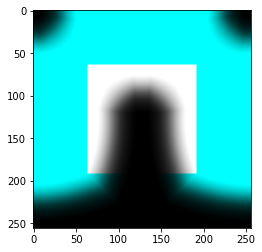

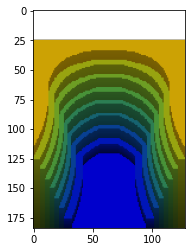

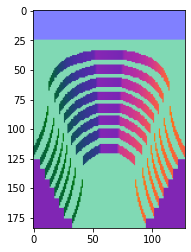

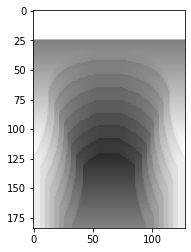

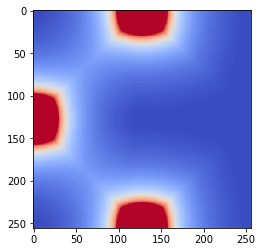

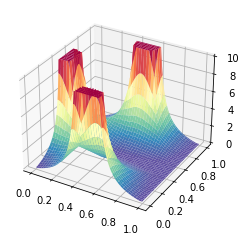

In [9]:
hmap, img, c_img, n_img, z_img = generate_images(0x0B)

plt.imshow(img)
plt.show()

plt.imshow(c_img)
plt.show()

plt.imshow(n_img)
plt.show()

plt.imshow(z_img)
plt.show()

shape = (src_base_w + border * 2, src_base_h + border * 2)

# See: https://jackmckew.dev/3d-terrain-in-python.html

plt.imshow(hmap, cmap=cm.coolwarm, interpolation='none')

# For plotting this in 3 dimensions, we must initialise 2 more arrays which will
# contain the x-y co-ordinates of our world.

lin_x = np.linspace(0, 1, shape[0], endpoint=False)
lin_y = np.linspace(0, 1, shape[1], endpoint=False)
x, y = np.meshgrid(lin_x, lin_y)

# Now it's time to plot in 3D with matplotlib

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, hmap, cmap=cm.Spectral_r)


In [10]:
last_tile = 0x101 # 0x200

num = 0
tile_codes = []
code_pos = {}
pos_code = {}
for code in range(last_tile):
    new_code = code
    if code & 0b00100011 == 0b00100011:
        new_code &= ~0b00100000
    if code & 0b01000110 == 0b01000110:
        new_code &= ~0b01000000
    if code & 0b10001100 == 0b10001100:
        new_code &= ~0b10000000
    if code & 0b00011001 == 0b00011001:
        new_code &= ~0b00010000
    if code != new_code:
        tile_codes.append(code_pos[new_code])
        continue
    #hmap, img, c_img, n_img, z_img = generate_images(code)
    #print (num)
    #plt.imshow(c_img)
    #plt.show()
    tile_codes.append(num)
    code_pos[code] = num
    pos_code[num] = code
    num += 1
last_pos = num
    
pprint([f"{c:>09b} ({c:3}): {p:3}" for c, p in code_pos.items()])
pprint([f"{p:3}: {c:>09b} ({c:3})" for p, c in pos_code.items()])
print(last_pos)

['000000000 (  0):   0',
 '000000001 (  1):   1',
 '000000010 (  2):   2',
 '000000011 (  3):   3',
 '000000100 (  4):   4',
 '000000101 (  5):   5',
 '000000110 (  6):   6',
 '000000111 (  7):   7',
 '000001000 (  8):   8',
 '000001001 (  9):   9',
 '000001010 ( 10):  10',
 '000001011 ( 11):  11',
 '000001100 ( 12):  12',
 '000001101 ( 13):  13',
 '000001110 ( 14):  14',
 '000001111 ( 15):  15',
 '000010000 ( 16):  16',
 '000010001 ( 17):  17',
 '000010010 ( 18):  18',
 '000010011 ( 19):  19',
 '000010100 ( 20):  20',
 '000010101 ( 21):  21',
 '000010110 ( 22):  22',
 '000010111 ( 23):  23',
 '000011000 ( 24):  24',
 '000011010 ( 26):  25',
 '000011100 ( 28):  26',
 '000011110 ( 30):  27',
 '000100000 ( 32):  28',
 '000100001 ( 33):  29',
 '000100010 ( 34):  30',
 '000100100 ( 36):  31',
 '000100101 ( 37):  32',
 '000100110 ( 38):  33',
 '000101000 ( 40):  34',
 '000101001 ( 41):  35',
 '000101010 ( 42):  36',
 '000101100 ( 44):  37',
 '000101101 ( 45):  38',
 '000101110 ( 46):  39',


  0: 000000000 (  0)


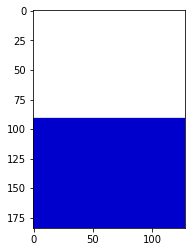

  1: 000000001 (  1)


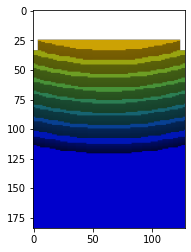

  2: 000000010 (  2)


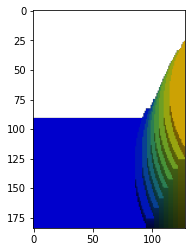

  3: 000000011 (  3)


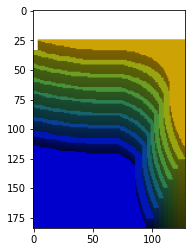

  4: 000000100 (  4)


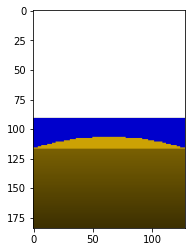

  5: 000000101 (  5)


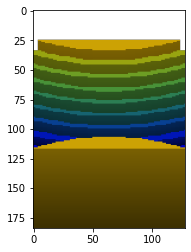

  6: 000000110 (  6)


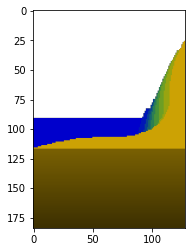

  7: 000000111 (  7)


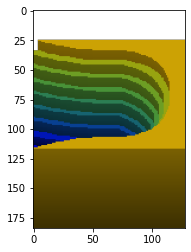

  8: 000001000 (  8)


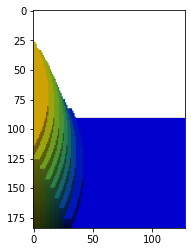

  9: 000001001 (  9)


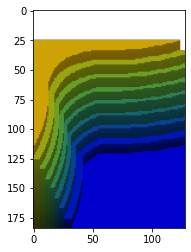

 10: 000001010 ( 10)


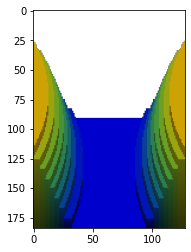

 11: 000001011 ( 11)


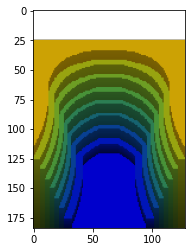

 12: 000001100 ( 12)


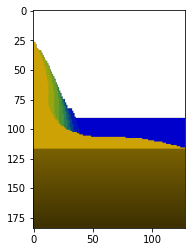

 13: 000001101 ( 13)


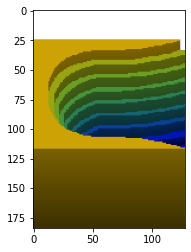

 14: 000001110 ( 14)


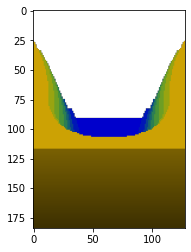

 15: 000001111 ( 15)


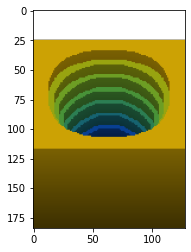

 16: 000010000 ( 16)


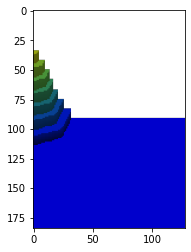

 17: 000010001 ( 17)


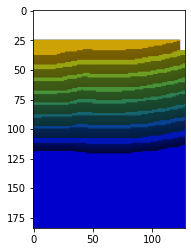

 18: 000010010 ( 18)


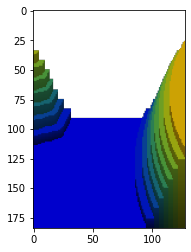

 19: 000010011 ( 19)


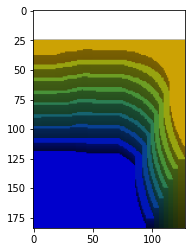

 20: 000010100 ( 20)


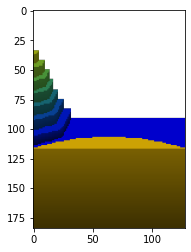

 21: 000010101 ( 21)


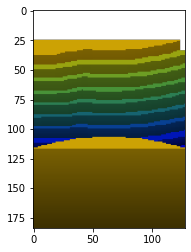

 22: 000010110 ( 22)


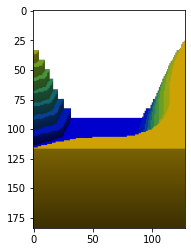

 23: 000010111 ( 23)


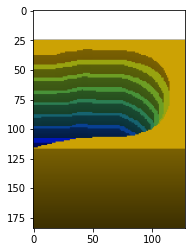

 24: 000011000 ( 24)


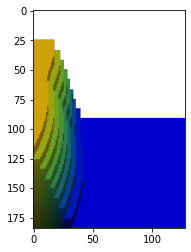

 25: 000011010 ( 26)


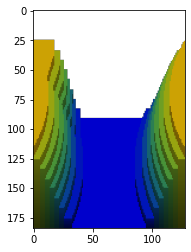

 26: 000011100 ( 28)


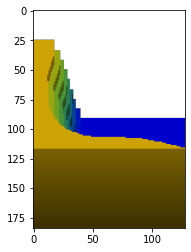

 27: 000011110 ( 30)


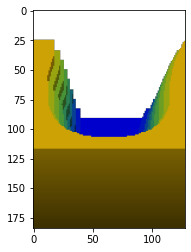

 28: 000100000 ( 32)


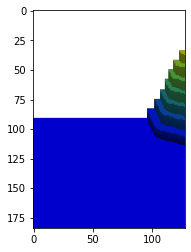

 29: 000100001 ( 33)


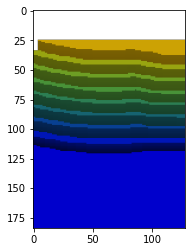

 30: 000100010 ( 34)


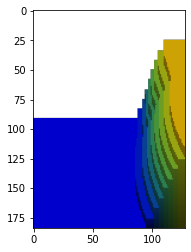

 31: 000100100 ( 36)


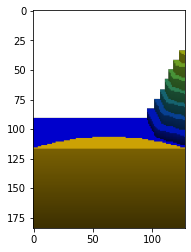

 32: 000100101 ( 37)


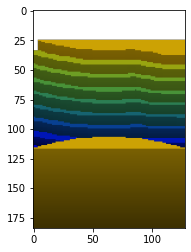

 33: 000100110 ( 38)


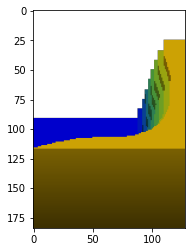

 34: 000101000 ( 40)


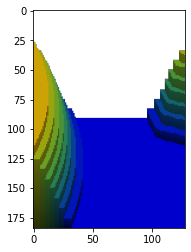

 35: 000101001 ( 41)


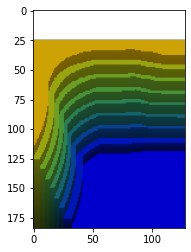

 36: 000101010 ( 42)


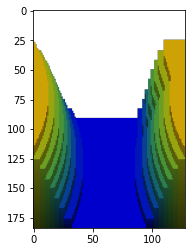

 37: 000101100 ( 44)


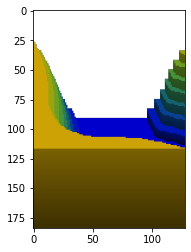

 38: 000101101 ( 45)


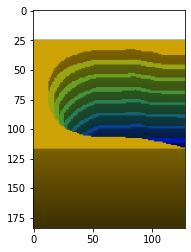

 39: 000101110 ( 46)


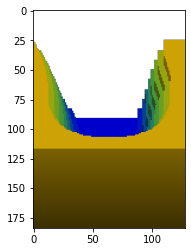

 40: 000110000 ( 48)


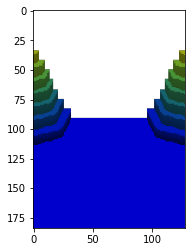

 41: 000110001 ( 49)


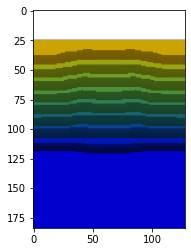

 42: 000110010 ( 50)


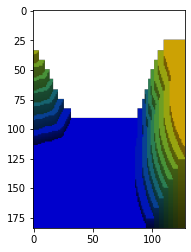

 43: 000110100 ( 52)


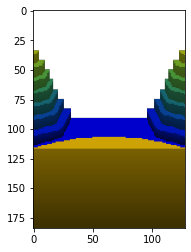

 44: 000110101 ( 53)


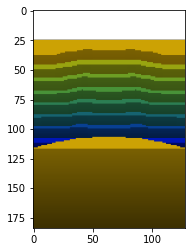

 45: 000110110 ( 54)


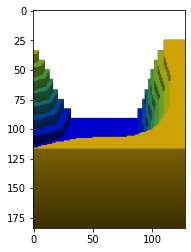

 46: 000111000 ( 56)


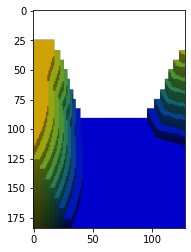

 47: 000111010 ( 58)


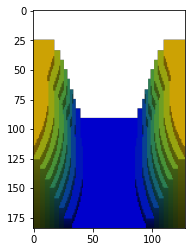

 48: 000111100 ( 60)


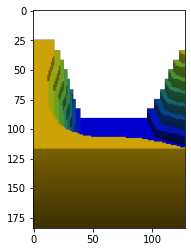

 49: 000111110 ( 62)


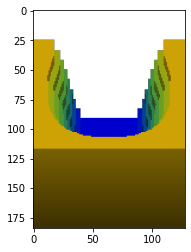

 50: 001000000 ( 64)


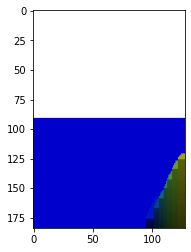

 51: 001000001 ( 65)


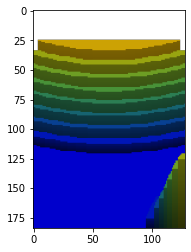

 52: 001000010 ( 66)


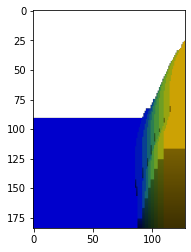

 53: 001000011 ( 67)


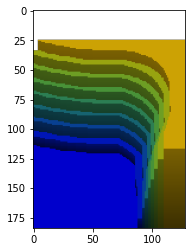

 54: 001000100 ( 68)


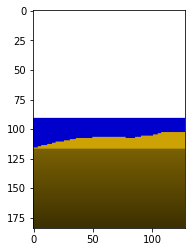

 55: 001000101 ( 69)


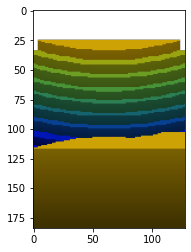

 56: 001001000 ( 72)


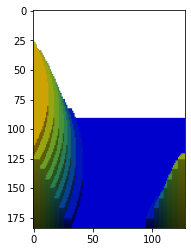

 57: 001001001 ( 73)


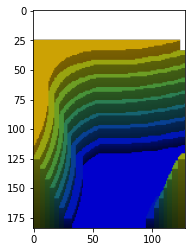

 58: 001001010 ( 74)


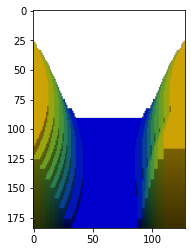

 59: 001001011 ( 75)


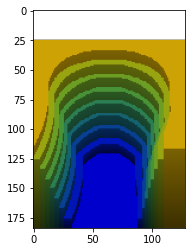

 60: 001001100 ( 76)


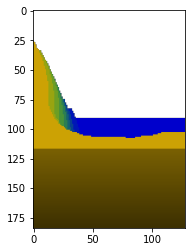

 61: 001001101 ( 77)


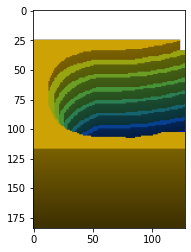

 62: 001010000 ( 80)


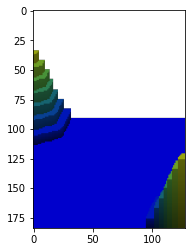

 63: 001010001 ( 81)


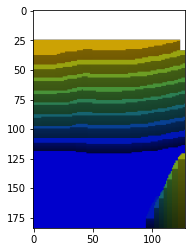

 64: 001010010 ( 82)


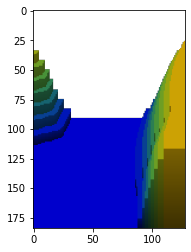

 65: 001010011 ( 83)


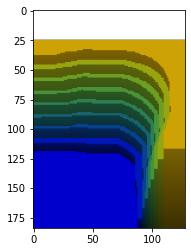

 66: 001010100 ( 84)


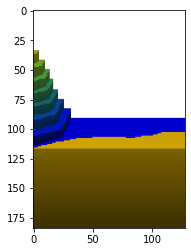

 67: 001010101 ( 85)


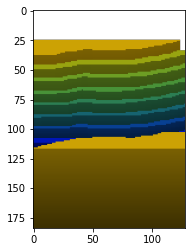

 68: 001011000 ( 88)


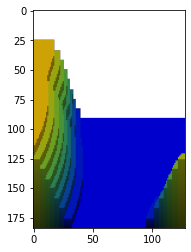

 69: 001011010 ( 90)


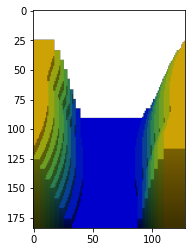

 70: 001011100 ( 92)


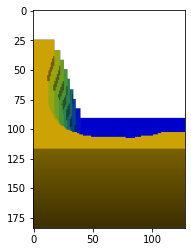

 71: 001100000 ( 96)


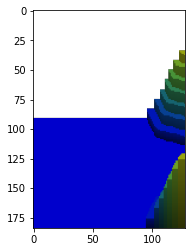

 72: 001100001 ( 97)


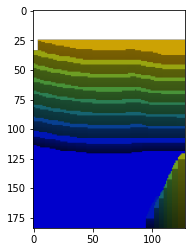

 73: 001100010 ( 98)


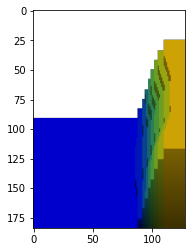

 74: 001100100 (100)


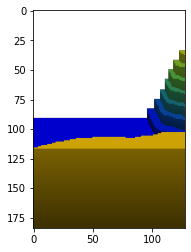

 75: 001100101 (101)


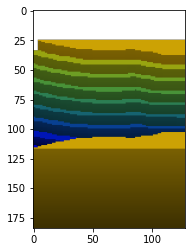

 76: 001101000 (104)


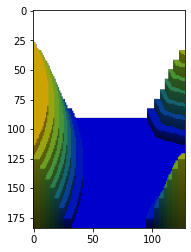

 77: 001101001 (105)


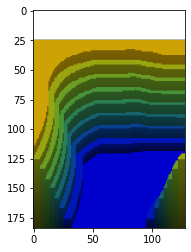

 78: 001101010 (106)


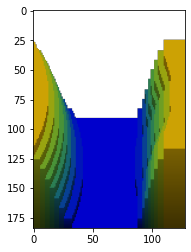

 79: 001101100 (108)


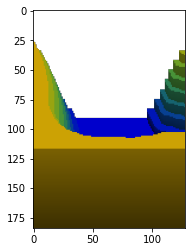

 80: 001101101 (109)


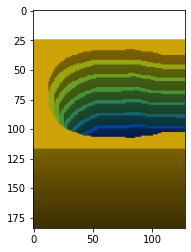

 81: 001110000 (112)


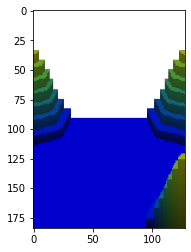

 82: 001110001 (113)


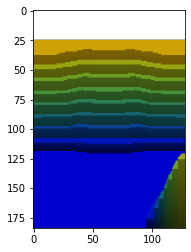

 83: 001110010 (114)


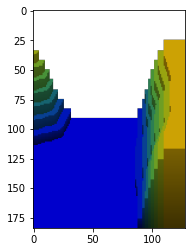

 84: 001110100 (116)


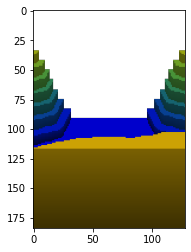

 85: 001110101 (117)


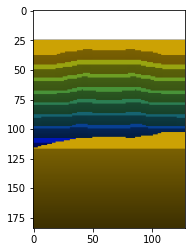

 86: 001111000 (120)


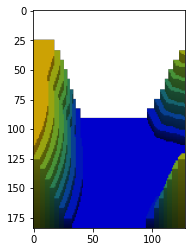

 87: 001111010 (122)


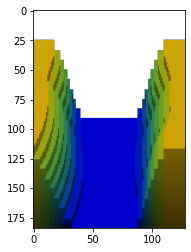

 88: 001111100 (124)


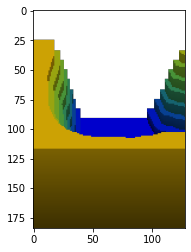

 89: 010000000 (128)


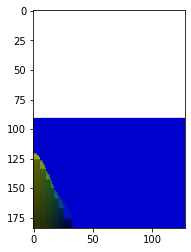

 90: 010000001 (129)


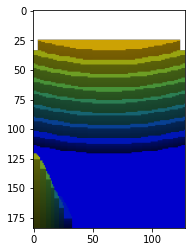

 91: 010000010 (130)


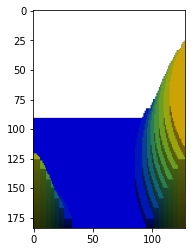

 92: 010000011 (131)


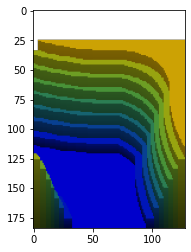

 93: 010000100 (132)


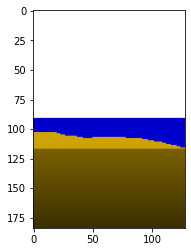

 94: 010000101 (133)


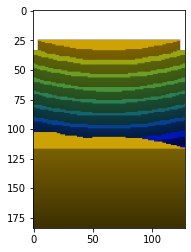

 95: 010000110 (134)


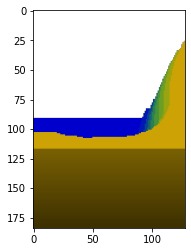

 96: 010000111 (135)


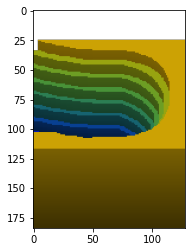

 97: 010001000 (136)


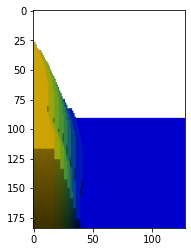

 98: 010001001 (137)


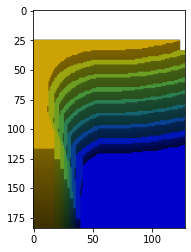

 99: 010001010 (138)


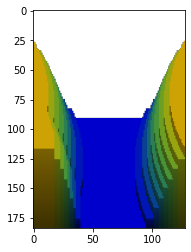

100: 010001011 (139)


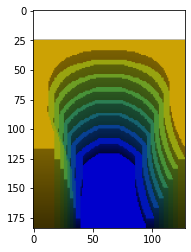

101: 010010000 (144)


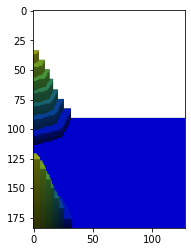

102: 010010001 (145)


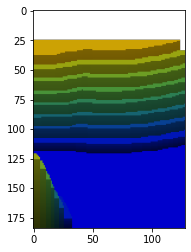

103: 010010010 (146)


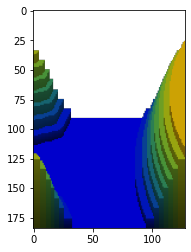

104: 010010011 (147)


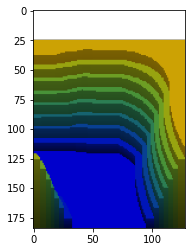

105: 010010100 (148)


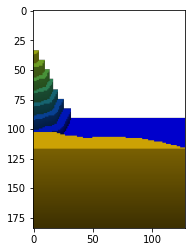

106: 010010101 (149)


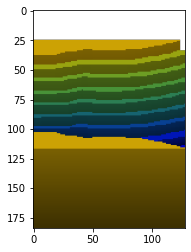

107: 010010110 (150)


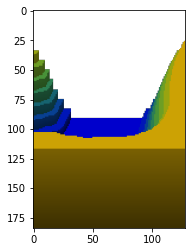

108: 010010111 (151)


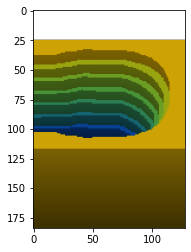

109: 010011000 (152)


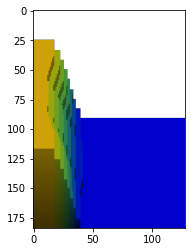

110: 010011010 (154)


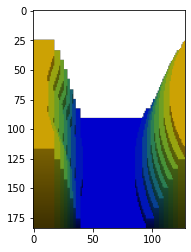

111: 010100000 (160)


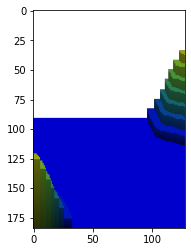

112: 010100001 (161)


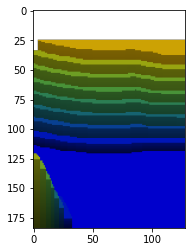

113: 010100010 (162)


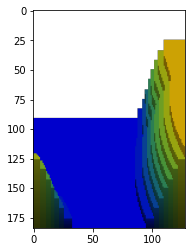

114: 010100100 (164)


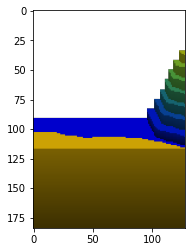

115: 010100101 (165)


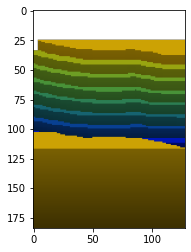

116: 010100110 (166)


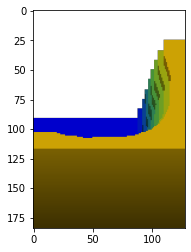

117: 010101000 (168)


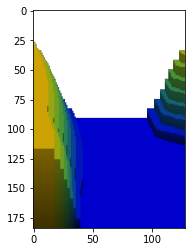

118: 010101001 (169)


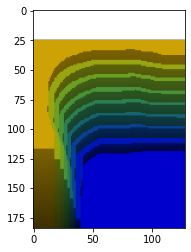

119: 010101010 (170)


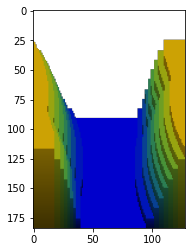

120: 010110000 (176)


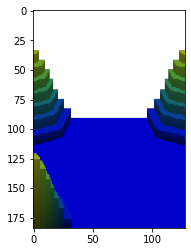

121: 010110001 (177)


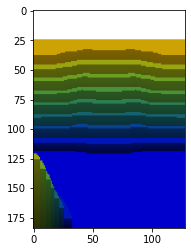

122: 010110010 (178)


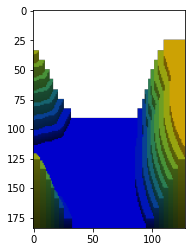

123: 010110100 (180)


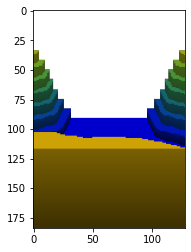

124: 010110101 (181)


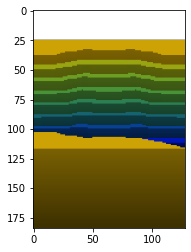

125: 010110110 (182)


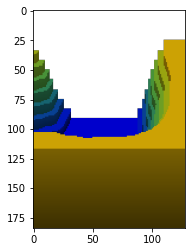

126: 010111000 (184)


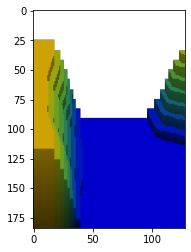

127: 010111010 (186)


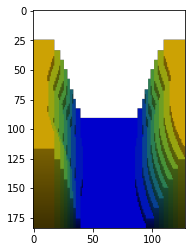

128: 011000000 (192)


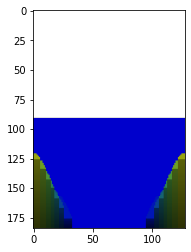

129: 011000001 (193)


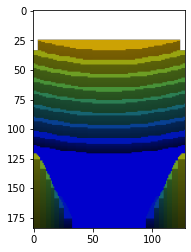

130: 011000010 (194)


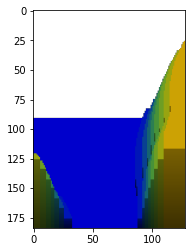

131: 011000011 (195)


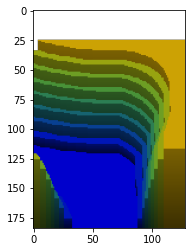

132: 011000100 (196)


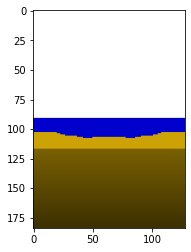

133: 011000101 (197)


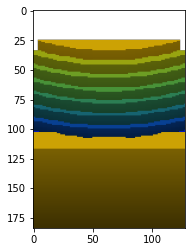

134: 011001000 (200)


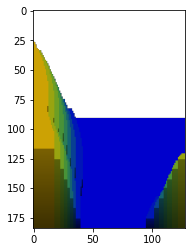

135: 011001001 (201)


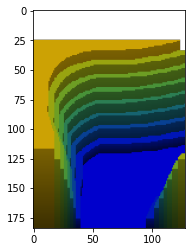

136: 011001010 (202)


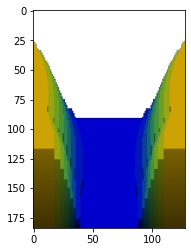

137: 011001011 (203)


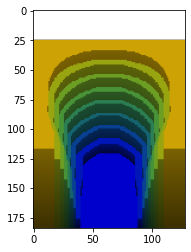

138: 011010000 (208)


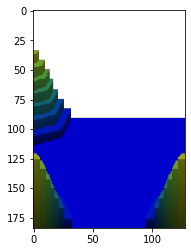

139: 011010001 (209)


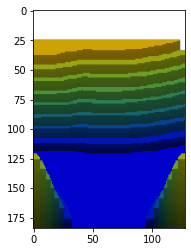

140: 011010010 (210)


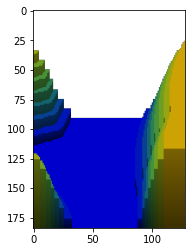

141: 011010011 (211)


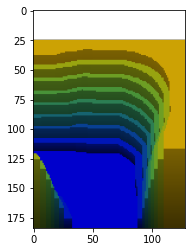

142: 011010100 (212)


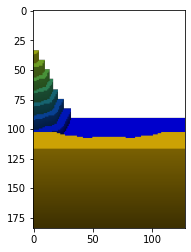

143: 011010101 (213)


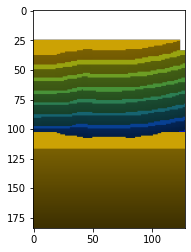

144: 011011000 (216)


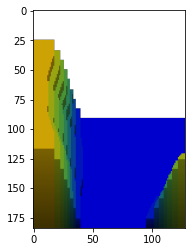

145: 011011010 (218)


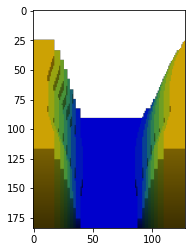

146: 011100000 (224)


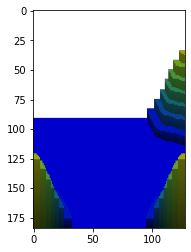

147: 011100001 (225)


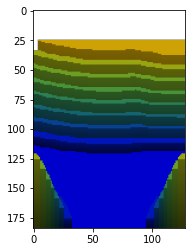

148: 011100010 (226)


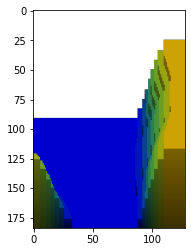

149: 011100100 (228)


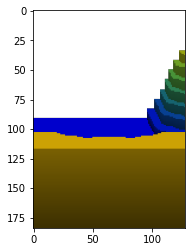

150: 011100101 (229)


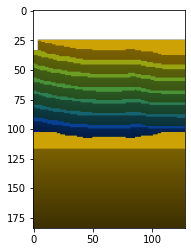

151: 011101000 (232)


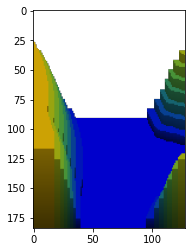

152: 011101001 (233)


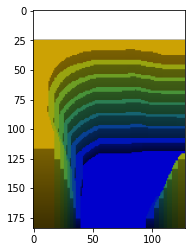

153: 011101010 (234)


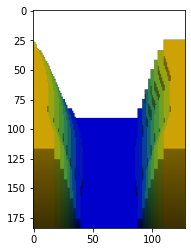

154: 011110000 (240)


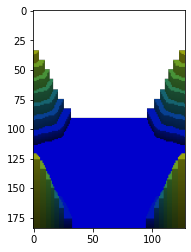

155: 011110001 (241)


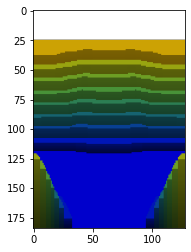

156: 011110010 (242)


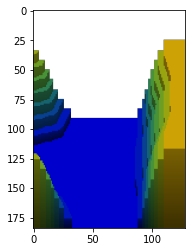

157: 011110100 (244)


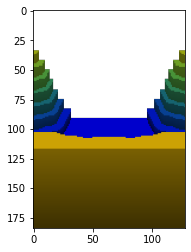

158: 011110101 (245)


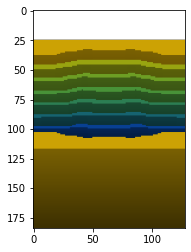

159: 011111000 (248)


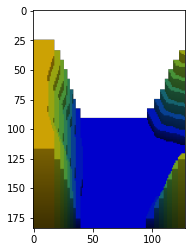

160: 011111010 (250)


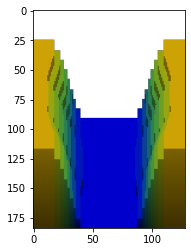

161: 100000000 (256)


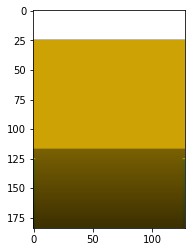

In [11]:
tiles_per_line = 16

tile_width  = src_base_w
tile_height = ( src_base_h * 23 // 32 ) * 2

tiles_width = tile_width * tiles_per_line
tiles_height = tile_height * ((last_pos + tiles_per_line - 1) // tiles_per_line)

tiles_img = Image.new('RGBA', (tiles_width, tiles_height), (0, 0, 0, 0) )
tiles_pixels = tiles_img.load()

normals_img = Image.new('RGBA', (tiles_width, tiles_height), (0, 0, 0, 0) )
normals_pixels = normals_img.load()

depth_img = Image.new('RGBA', (tiles_width, tiles_height), (0, 0, 0, 0) )
depth_pixels = depth_img.load()

for pos, code in pos_code.items():
    hbase = (pos % tiles_per_line) * tile_width
    vbase = (pos // tiles_per_line) * tile_height

    print(f"{pos:3}: {code:>09b} ({code:3})")

    hmap, img, c_img, n_img, z_img = generate_images(code)

    #plt.imshow(img)
    #plt.show()

    plt.imshow(c_img)
    plt.show()

    for y in range(tile_height):
        for x in range(tile_width):
            r, g, b, a = c_img.getpixel((x, y))
            tiles_pixels[hbase + x, vbase + y] = ( int(r), int(g), int(b), int(a) )
            r, g, b, a = n_img.getpixel((x, y))
            normals_pixels[hbase + x, vbase + y] = ( int(r), int(g), int(b), int(a) )
            r, g, b, a = z_img.getpixel((x, y))
            depth_pixels[hbase + x, vbase + y] = ( int(r), int(g), int(b), int(a) )

    #plt.imshow(n_img)
    #plt.show()


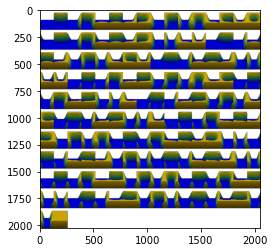

In [12]:
plt.imshow(tiles_img)
plt.show()
tiles_img.save("VoxTest9_Color.png", format="png")

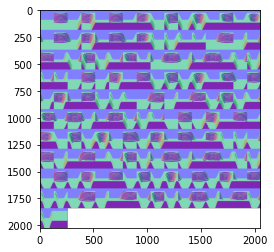

In [13]:
plt.imshow(normals_img)
plt.show()
normals_img.save("VoxTest9_Normals.png", format="png")

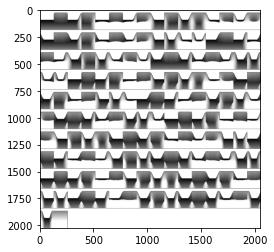

In [14]:
plt.imshow(depth_img)
plt.show()
normals_img.save("VoxTest9_Depth.png", format="png")

Code 000001011 ( 11 / 0x0B)


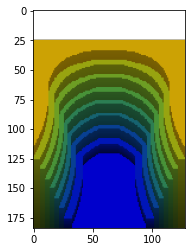

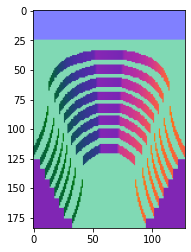

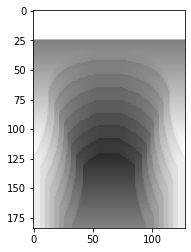

In [15]:
tile_width  = src_base_w
tile_height = ( src_base_h * 23 // 32 ) * 2

c_img = Image.new('RGBA', (tile_width, tile_height), (0, 0, 0, 0) )
c_pixels = c_img.load()
n_img = Image.new('RGBA', (tile_width, tile_height), (0, 0, 0, 0) )
n_pixels = n_img.load()
z_img = Image.new('RGBA', (tile_width, tile_height), (0, 0, 0, 0) )
z_pixels = n_img.load()

for code in [ 0x0B ]:
    hbase = 0
    vbase = 0

    print(f"Code {code:>09b} ({code:3} / 0x{code:02X})")

    hmap, img, c_img, n_img, z_img = generate_images(code)

    plt.imshow(c_img)
    plt.show()

    plt.imshow(n_img)
    plt.show()

    plt.imshow(z_img)
    plt.show()
